# Dice Detection Project
Dice detection project for Computer Vision (include description)

## 1. Import Dependencies

In [1]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

import kagglehub
from ultralytics import YOLO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

C:\Users\samal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project constants

In [2]:
path = kagglehub.dataset_download("nellbyler/d6-dice")
print("Path to dataset files:", path)

# ANNOTATION_PATH = path + "/d6-dice/Annotations"
# IMAGE_PATH = path + "/d6-dice/Images"

ANNOTATION_PATH = os.path.join(path, "d6-dice", "Annotations")
IMAGE_PATH = os.path.join(path, "d6-dice", "Images")

# windows delim
split_char = '\\'

# linux delim
#split_char = '/'

Path to dataset files: C:\Users\samal\.cache\kagglehub\datasets\nellbyler\d6-dice\versions\3


## 2. Split data into train/test/validation

In [3]:
anotation_files = []
for dir,_,files in os.walk(ANNOTATION_PATH):
    for filename in files:
        if filename[-4:] == '.txt':
            anotation_files += [(os.path.join(dir,filename))]

# remove classes.txt file from image pool
anotation_files.pop(0)

# 70/15/15 train-test split
train_ratio = .7
test_ratio = (1.0 - train_ratio) / 2
valid_ratio = test_ratio

SIZE = len(anotation_files)
N = list(range(SIZE))

train_size = int(SIZE * train_ratio)
test_size = int(SIZE * test_ratio)
valid_size = int(SIZE * valid_ratio)

# Add any files that might have been accidentally skipped to the train set
while((train_size + test_size + valid_size) < len(anotation_files)):
    train_size += 1

print(train_size)
print(test_size)
print(valid_size)
print(len(anotation_files))

176
37
37
250


## 3. Organize and prep data for YOLO

In [4]:
# Create directories if they don't exist
os.makedirs('datasets/train/images', exist_ok=True)
os.makedirs('datasets/train/labels', exist_ok=True)

os.makedirs('datasets/test/images', exist_ok=True)
os.makedirs('datasets/test/labels', exist_ok=True)

os.makedirs('datasets/valid/images', exist_ok=True)
os.makedirs('datasets/valid/labels', exist_ok=True)

# helper to organize files into their respective directories
def copy_files(i, dir, ano_files):
    # get the image filename
    ano_file = ano_files[i]
    img_file = ano_file.split(split_char)[-1][0:-4] + '.jpg'

    # copy into folders
    shutil.copy(ano_file, dir + '/labels')
    shutil.copy(os.path.join(IMAGE_PATH, img_file), os.path.join(dir + '/images/', img_file))

# copy image and label files into local directories
for i in range(train_size):
    copy_files(i, './datasets/train', anotation_files)

test_start = train_size + valid_size
test_end = test_start + test_size
for i in range(test_start, test_end):
    copy_files(i, './datasets/test', anotation_files)


valid_start = train_size
valid_end = valid_start + valid_size
for i in range(valid_start, valid_end):
    copy_files(i, './datasets/valid', anotation_files)

In [5]:
import yaml

source_path = current_directory = os.getcwd()

train_path = os.path.join(source_path, "datasets", "train")
test_path = os.path.join(source_path, "datasets", "test")
valid_path = os.path.join(source_path, "datasets", "valid")

data_yaml = dict(
    train = train_path,
    test = test_path,
    val = valid_path,
    
    nc = 6,
    names = list('123456'),
    device = 'cpu'
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [6]:
# load model
model = YOLO("yolo11x.pt")  # build from YAML and transfer weights

## 4. Train Model

In [ ]:
train_results = model.train(
    data = "./data.yaml",
    epochs = 12,
    imgsz = 480
)

New https://pypi.org/project/ultralytics/8.3.47 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.39  Python-3.11.9 torch-2.5.1+cpu CPU (AMD Ryzen 7 5800X 8-Core Processor)
engine\trainer: task=detect, mode=train, model=yolo11x.pt, data=./data.yaml, epochs=12, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\Users\samal\Computer-vision-project\DiceRollDetection\datasets\train\labels.cache... 249 images, 0 backgrounds, 0 corrupt: 100%|██████████| 249/249 [00:00<?, ?it/s]
val: Scanning C:\Users\samal\Computer-vision-project\DiceRollDetection\datasets\valid\labels.cache... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<?, ?it/s]



optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)


## 5. Masking

In [7]:
pred_dataset_path = kagglehub.dataset_download("koryakinp/d6-dices-images")

dataset_images = os.path.join(pred_dataset_path, "dataset-images")

print(pred_dataset_path)

image_dir = os.listdir(os.path.join(pred_dataset_path, 'dataset-images'))
image_list = []
for file in image_dir:
    image_list.append(os.path.join(pred_dataset_path,'dataset-images', file))

print(image_list[0])

C:\Users\samal\.cache\kagglehub\datasets\koryakinp\d6-dices-images\versions\2
C:\Users\samal\.cache\kagglehub\datasets\koryakinp\d6-dices-images\versions\2\dataset-images\0001091d-6438-4cc3-bb80-a79534f9ccd8.jpg


In [8]:
masked_images = []

Mask images

In [ ]:
os.makedirs('test_images/masked_images', exist_ok=True)

def save_im(image_path, result):
    cv2.imwrite(image_path, result)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i in range(len(image_list)):
        image = cv2.imread(image_list[i])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, dice_mask = cv2.threshold(gray_image, 125, 255, cv2.THRESH_BINARY_INV)
        result = cv2.bitwise_and(image, image, mask=dice_mask)
        result[dice_mask == 0] = [255, 255, 255]
        result[dice_mask != 0] = [0, 0, 0]

        #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        #plt.axis("off")
        #plt.title("Masked Dice")
        #plt.show()
        #masked_images.append(result)

        image_name = 'masked_image'+str(i)+'.jpg'

        im_name = os.path.join('test_images', 'masked_images', image_name)
        masked_images.append(im_name)

        # output to file
        futures.append(executor.submit(save_im, im_name, result))

    # wait to retrieve all futures
    for future in futures:
        future.result()

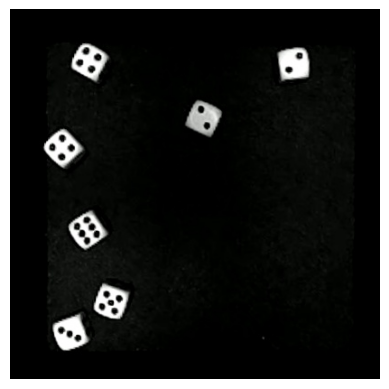

In [9]:
def show_image(image_path):
    # Load the image from the directory
    image = Image.open(image_path)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

show_image(image_list[1])

## 6. Predict Using a Different Dataset

In [10]:
def get_results(results, image_list, file_name):
    keys = [0, 1, 2, 3, 4, 5]
    values = [1, 2, 3, 4, 5, 6]

    image_list = sorted(image_list)

    class_dict = dict(zip(keys, values))

    data = pd.DataFrame(columns= range(6))
    for i in range(len(results)):
        # add the data to a Data Frame
        result = pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
        
        # append the 
        file = image_list[i]
        result['img index'] = int(i)
        result['file'] = file

        data = pd.concat([data, result], axis=0)

    # rename columns
    data.columns = ['x', 'y', 'x2', 'y2', 'cl', 'label', 'i', 'file']

    # apply correct labellings
    data['label'] = data['label'].map(class_dict)
    data['i'] = data['i'].astype(int)
    data = data.reset_index(drop=True)

    # output data
    os.makedirs("results", exist_ok=True)
    data.to_csv(os.path.join("results", "data", file_name + ".csv"), index=False, header=True)

    display(data)
    
    return data

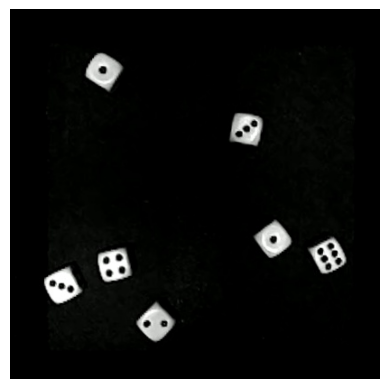

In [11]:
show_image(image_list[21])

Predict bounding boxes and values of the dice in another dataset

In [12]:
trained_model = YOLO(os.path.join("runs", "detect", "Best_run", "best.pt"))
#trained_model_e20 = YOLO(os.path.join("runs", "detect", "train", "weights", "best.pt"))

Predict with epoch = 12

In [42]:
results = trained_model.predict(source=image_list[:20], conf=0.15)
#results_masked = trained_model.predict(source=masked_images[:20], conf=0.2)


0: 480x480 1 1, 3 2s, 1 4, 2 6s, 409.4ms
1: 480x480 1 1, 2 2s, 1 3, 2 4s, 1 5, 1 6, 409.4ms
2: 480x480 1 1, 1 2, 2 3s, 2 4s, 2 5s, 409.4ms
3: 480x480 1 1, 2 3s, 1 4, 1 5, 2 6s, 409.4ms
4: 480x480 2 1s, 2 2s, 2 4s, 1 5, 2 6s, 409.4ms
5: 480x480 2 2s, 2 5s, 2 6s, 409.4ms
6: 480x480 1 1, 1 2, 1 3, 1 5, 2 6s, 409.4ms
7: 480x480 1 1, 2 3s, 1 4, 3 5s, 409.4ms
8: 480x480 1 1, 1 2, 1 3, 1 4, 3 6s, 409.4ms
9: 480x480 2 2s, 2 3s, 2 5s, 409.4ms
10: 480x480 1 1, 2 4s, 1 5, 2 6s, 409.4ms
11: 480x480 2 2s, 3 3s, 1 4, 1 5, 409.4ms
12: 480x480 2 1s, 3 2s, 1 4, 1 5, 409.4ms
13: 480x480 3 1s, 1 2, 1 3, 2 6s, 409.4ms
14: 480x480 2 1s, 1 3, 2 4s, 1 5, 1 6, 409.4ms
15: 480x480 1 1, 2 2s, 2 3s, 1 4, 1 6, 409.4ms
16: 480x480 1 1, 2 3s, 1 4, 1 5, 409.4ms
17: 480x480 1 1, 1 2, 2 3s, 3 4s, 1 5, 409.4ms
18: 480x480 1 1, 2 2s, 1 3, 2 6s, 409.4ms
19: 480x480 2 1s, 5 6s, 409.4ms
Speed: 1.8ms preprocess, 409.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 480)


Predict with epoch=20

In [33]:
#results_e20 = trained_model_e20.predict(source=image_list[:20], conf=0.2)
#results_e20_masked = trained_model_e20.predict(source=masked_images[:20], conf=0.2)

Generate Data Frames

In [43]:
os.makedirs(os.path.join("results","data"), exist_ok=True)

orig_df = get_results(results, image_list, "orig_e12")
#masked_df = get_results(results_masked, masked_images, "masked_e12")

#orig_df_e20 = get_results(results_e20, image_list, "orig_e20")
#masked_df_e20 = get_results(results_e20_masked, masked_images, "masked_e20")

,x,y,x2,y2,cl,label,i,file
0,61.996593,37.276604,108.062347,86.457336,0.833654,6,0,C:\Users\samal\.cache\kagglehub\datasets\korya...
1,86.018509,139.464722,130.054459,185.709045,0.775985,4,0,C:\Users\samal\.cache\kagglehub\datasets\korya...
2,343.220398,343.297852,387.227692,389.343414,0.698493,6,0,C:\Users\samal\.cache\kagglehub\datasets\korya...
3,120.387375,115.431732,165.779480,161.415665,0.634612,2,0,C:\Users\samal\.cache\kagglehub\datasets\korya...
4,36.675716,329.691193,85.995949,379.978027,0.600264,1,0,C:\Users\samal\.cache\kagglehub\datasets\korya...
...,...,...,...,...,...,...,...,...
133,52.220547,29.744892,99.462936,79.666786,0.738920,6,19,C:\Users\samal\.cache\kagglehub\datasets\korya...
134,100.043999,151.798965,148.962723,201.485504,0.724608,6,19,C:\Users\samal\.cache\kagglehub\datasets\korya...
135,49.497368,75.397453,96.046951,118.605194,0.722915,6,19,C:\Users\samal\.cache\kagglehub\datasets\korya...
136,149.395309,336.884979,196.092697,383.578888,0.383583,1,19,C:\Users\samal\.cache\kagglehub\datasets\korya...


## 7. Remove duplicate bounding boxes

Helper Functions

In [44]:
def coincides(b1, b2, scale=0.1):
    # bounding box (BB) 1 diagonal length
    p1 = np.array([b1[0], b1[1]])
    p2 = np.array([b1[2], b1[3]])
    threshold = np.linalg.norm(p1 - p2) * scale

    # distance between BB 1 and BB 2
    p1 = np.array([b1[0], b1[1]])
    p2 = np.array([b2[0], b2[1]])
    dist = np.linalg.norm(p1 - p2)
    
    return dist < threshold

Removal of Extra Bounding Boxes

In [45]:
# compare bounding boxes
def compare_boxes(data, cl):
    remove_idx = []
    for i in range(len(data)):
        # if data was already removed, then skip
        if i in remove_idx:
            continue
        
        # obtain first bounding box
        b1 = data[i]

        for j in range(len(data)):
            # if data was already removed, then skip
            if j in remove_idx:
                continue

            # obtain second bounding box
            b2 = data[j]

            if np.array_equiv(b1, b2):
                continue
            
            # if 2 bounding boxes coincide, then take the value with the higher confidence level
            if coincides(b1, b2, .05):
                remove_idx.append(j if cl[i] > cl[j] else i)
    
    return remove_idx

# remove any duplicate bounding boxes
def remove_dup_BB(df):
    max_index = df.iloc[-1]['i'] + 1

    offset = 0
    remove_idx = []
    for index in range(max_index):
        # remove the label, confidence level, image index, and image path
        view = df[df['i'] == index].iloc[:, :-4]
        cl = df[df['i'] == index]['cl']
        cl = cl.reset_index(drop=True)

        # remove duplicate bounding boxes
        dup_idx = compare_boxes(view.to_numpy(), cl)
        dup_idx = [i + offset for i in dup_idx]

        remove_idx.extend(dup_idx)

        # increment offset
        offset = offset + len(view)

    # filter out wrong bounding boxes
    if remove_idx:
        filtered_df = df.drop(remove_idx)
    else:
        return df

    return filtered_df

Output dataframe to csv

In [46]:
os.makedirs(os.path.join("results","filtered"), exist_ok=True)

filtered_orig_e12_df = remove_dup_BB(orig_df)
filtered_orig_e12_df.to_csv(os.path.join("results", "filtered", "filtered_orig.csv"), index=False, header=True)

#filtered_orig_e20_df = remove_dup_BB(orig_df_e20)
#filtered_orig_e20_df.to_csv(os.path.join("results", "filtered", "filtered_orig_e20.csv"), index=False, header=True)

#filtered_mask_e12_df = remove_dup_BB(masked_df)
#filtered_mask_e12_df.to_csv(os.path.join("results", "filtered", "filtered_masked.csv"), index=False, header=True)

#filtered_mask_e20_df = remove_dup_BB(masked_df_e20)
#filtered_mask_e20_df.to_csv(os.path.join("results", "filtered", "filtered_masked_e20.csv"), index=False, header=True)

show removed results

In [62]:
# display difference
def show_diff(orig, filt):
    display(pd.concat([orig, filt]).drop_duplicates(keep=False))

print("epoch=12")
show_diff(orig_df, filtered_orig_e12_df)
#show_diff(masked_df, filtered_mask_e12_df)

#print("epoch=20")
#show_diff(orig_df_e20, filtered_orig_e20_df)
#show_diff(masked_df_e20, filtered_mask_e20_df)

epoch=12


,x,y,x2,y2,cl,label,i,file
14,191.532761,98.092041,238.308441,144.885757,0.372011,2,1,C:\Users\samal\.cache\kagglehub\datasets\korya...
22,311.861084,148.450592,356.875061,195.751160,0.330793,1,2,C:\Users\samal\.cache\kagglehub\datasets\korya...
36,82.605530,214.055832,128.702499,263.335663,0.333972,4,4,C:\Users\samal\.cache\kagglehub\datasets\korya...
37,34.670265,204.045319,82.824814,255.474045,0.289782,5,4,C:\Users\samal\.cache\kagglehub\datasets\korya...
38,261.434601,247.472229,306.331360,289.357147,0.220903,1,4,C:\Users\samal\.cache\kagglehub\datasets\korya...
63,38.175789,332.483093,85.061493,380.079010,0.410066,1,8,C:\Users\samal\.cache\kagglehub\datasets\korya...
64,39.445827,112.090378,92.508392,166.210785,0.283612,6,8,C:\Users\samal\.cache\kagglehub\datasets\korya...
83,53.390930,127.433014,106.573120,181.311569,0.161415,3,11,C:\Users\samal\.cache\kagglehub\datasets\korya...
90,116.913452,96.304688,158.833099,140.750809,0.258907,1,12,C:\Users\samal\.cache\kagglehub\datasets\korya...
111,98.292549,234.745010,144.660126,281.513000,0.310034,2,15,C:\Users\samal\.cache\kagglehub\datasets\korya...


In [63]:
dict_list = []
i = 0

roll_map = {1:0,
            2:0,
            3:0,
            4:0,
            5:0,
            6:0}
for file,label in zip(filtered_orig_e12_df['i'], filtered_orig_e12_df['label']):
    if(file!=i):
        i = file
        #print(roll_map)
        dict_list.append(roll_map)
        roll_map = {1:0,
                    2:0,
                    3:0,
                    4:0,
                    5:0,
                    6:0}
        continue
    roll_map[label]+=1
dict_list.append(roll_map)

## 8. UI Output

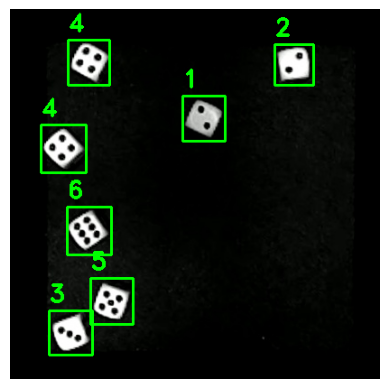

In [64]:
# draws bounding box for a dataframe
def draw_BB(df, img_path):
    image = cv2.imread(img_path)

    for _, row in df.iterrows():
        # obtain data from dataframe
        label = int(row['label'])
        x1, y1, x2, y2 = int(row['x']), int(row['y']), int(row['x2']), int(row['y2'])
        
        # Draw the bounding box with the label
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(label), (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 0.9, (0, 255, 0), 2)

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

# example
index = 1
trunc_df = filtered_orig_e12_df[filtered_orig_e12_df['i'] == index]
img_path = image_list[index]
output = draw_BB(trunc_df, img_path)

plt.imshow(output)
plt.axis('off')
plt.show()

In [67]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk  # Use PIL for image handling

index = 1

rolls = dict_list[index]
image_path = image_list[index]
sum = rolls[1] + rolls[2]*2 + rolls[3]*3 + rolls[4]*4 + rolls[5]*5 + rolls[6]*6

data = [["1's", rolls[1]],
        ["2's", rolls[2]],
        ["3's", rolls[3]],
        ["4's", rolls[4]],
        ["5's", rolls[5]],
        ["6's", rolls[6]],
        ["SUM", sum]]

# Create the main application window
root = tk.Tk()
root.title("Table with Image Example")

# Create a style for the Treeview
style = ttk.Style()
style.configure("Treeview", font=("Helvetica", 14))
style.configure("Treeview.Heading", font=("Helvetica", 16, "bold"))

# Frame to hold the table and image
main_frame = tk.Frame(root)
main_frame.pack(expand=True, fill=tk.BOTH)

# Add a treeview for the table
table_frame = tk.Frame(main_frame)
table_frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH, padx=10, pady=10)

columns = ["Dice #", "Roll count"]
tree = ttk.Treeview(table_frame, columns=columns, show="headings")
for col in columns:
    tree.heading(col, text=col)
    tree.column(col, width=120, anchor="center")

for row in data:
    tree.insert("", tk.END, values=row)

tree.pack(expand=True, fill=tk.BOTH)

# Add an image to the side
image_frame = tk.Frame(main_frame)
image_frame.pack(side=tk.RIGHT, padx=10, pady=10)

# get dataframe at image index
image_df = filtered_orig_e12_df[filtered_orig_e12_df['i'] == index]

try:
    # HELLO IM CHANGING THIS - Alex
    # img = Image.open(image_path)
    # img = img.resize((250, 250))  # Resize the image to fit
    img = draw_BB(image_df, image_path)
    img = Image.fromarray(img)
    img.resize((250, 250))
    tk_img = ImageTk.PhotoImage(img)

    # Display the image in a Label and keep the reference
    image_label = tk.Label(image_frame, image=tk_img)
    image_label.image = tk_img  # Keep a reference to avoid garbage collection
    image_label.pack()
except FileNotFoundError:
    image_label = tk.Label(image_frame, text="Image not found", font=("Helvetica", 14))
    image_label.pack()
except Exception as e:
    print(f"An unexpected error occurred: {e}")  # Debugging fallback

# Start the application
root.mainloop()